In [227]:
# imports and setup
import os, time
from pathlib import Path
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import nltk
import re
import string
from html import unescape
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from gensim.utils import simple_preprocess
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import numpy as np
import joblib
nltk.download('stopwords')
nltk.download('punkt')
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")
os.makedirs('figures', exist_ok=True)
os.makedirs('data', exist_ok=True)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fatema\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fatema\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Constants 
SENTIMENT = 'review_score'
NEGATIVE_SENTIMENT = '#e15759'
POSITIVE_SENTIMENT = '#4e79a7'
TARGET_PALLETTE = {-1: NEGATIVE_SENTIMENT, 1: POSITIVE_SENTIMENT }

STOP_WORDS = set(stopwords.words('english'))
STEMMER = SnowballStemmer('english') # better than PorterStemmer


### 1 - Data Acquisition: Import the Dataset from Kaggle
- Dataset (Kaggle): [steam-reviews](https://www.kaggle.com/datasets/andrewmvd/steam-reviews/data)

- Dataset (local): [data/dataset.csv](data/dataset.csv)


In [45]:
# Optional - Dataset included under data directory
path = kagglehub.dataset_download("andrewmvd/steam-reviews")

In [46]:
# Optional 
path

'C:\\Users\\Fatema\\.cache\\kagglehub\\datasets\\andrewmvd\\steam-reviews\\versions\\3'

In [47]:
# Optional: 
# On windows terminal use
! copy $path\dataset.csv data\

# on unix terminal use
# ! cp $path\dataset.csv data\


        1 file(s) copied.


In [48]:
df = pd.read_csv('data/dataset.csv')

In [147]:
df.shape

(6417106, 5)

In [49]:
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [51]:
df.describe()

,app_id,review_score,review_votes
count,6.417106e+06,6.417106e+06,6.417106e+06
mean,2.274695e+05,6.394992e-01,1.472446e-01
std,1.260451e+05,7.687918e-01,3.543496e-01
min,1.000000e+01,-1.000000e+00,0.000000e+00
25%,2.018100e+05,1.000000e+00,0.000000e+00
50%,2.391600e+05,1.000000e+00,0.000000e+00
75%,3.056200e+05,1.000000e+00,0.000000e+00
max,5.653400e+05,1.000000e+00,1.000000e+00


### 2- Exploratory Data Analysis and Preprocessing

#### 2.1 Explore the data and clean based on observations

In [52]:
print('Number of games reviewed: {}'.format(df['app_id'].nunique())) # how many games are there?

Number of games reviewed: 9972


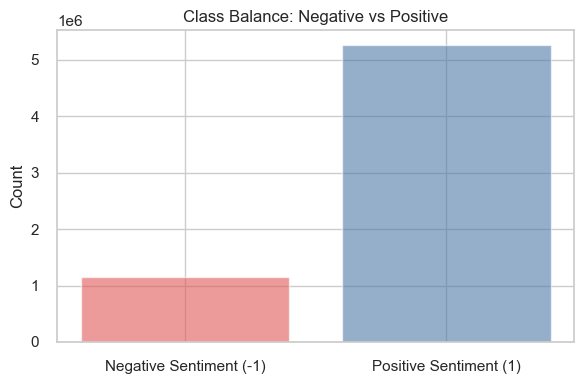

In [53]:
fig, ax = plt.subplots(figsize=(6,4))
counts = df[SENTIMENT].value_counts().sort_index()
ax.bar(x=['Negative Sentiment (-1)', 'Positive Sentiment (1)'],height=counts.values, color=[NEGATIVE_SENTIMENT,POSITIVE_SENTIMENT], alpha=0.6)
ax.set_title('Class Balance: Negative vs Positive')
ax.set_ylabel('Count')
fig.tight_layout()
plt.savefig('figures/sentiment_class_balance.png')

In [54]:
def make_balanced_subset(
    csv_path: str = "data/dataset.csv",
    score_col: str = "review_score",
    classes: tuple = (-1, 1),
    total_target: int = 500_000,
    random_state: int = 42,
    save_path: str = "data/new_dataset",
    save_format: str = "csv",
    oversample_if_needed: bool = True
) -> pd.DataFrame:
    """
    Create a balanced subset of size `total_target` across `classes`.
    If any class has < target_per_class, optionally oversample with replacement.

    Returns the balanced DataFrame. Optionally saves to Parquet/CSV.
    """
    assert total_target % len(classes) == 0, "total_target must be divisible by number of classes."
    target_per_class = total_target // len(classes)

    # 1) Load
    df = pd.read_csv(csv_path)

    # 2) Keep only the desired classes (robust to stray values)
    df = df[df[score_col].isin(classes)].copy()

    # 3) Count per class
    counts = df[score_col].value_counts().reindex(classes).fillna(0).astype(int)
    print("Class counts before balancing:", counts.to_dict())

    # 4) For each class: sample appropriately
    parts = []
    for c in classes:
        df_c = df[df[score_col] == c]

        if len(df_c) >= target_per_class:
            # Downsample without replacement
            part = df_c.sample(n=target_per_class, replace=False, random_state=random_state)
        else:
            if oversample_if_needed:
                # Sample with replacement to reach target
                part = df_c.sample(n=target_per_class, replace=True, random_state=random_state)
                print(f"Warning: Class {c} had only {len(df_c)} rows; oversampling with replacement to {target_per_class}.")
            else:
                # Take what we have (no replacement), and total will be smaller than requested
                part = df_c.sample(n=len(df_c), replace=False, random_state=random_state)
                print(f"Notice: Class {c} limited to {len(df_c)} rows (no oversampling).")

        parts.append(part)

    # 5) Concatenate, shuffle, reset index
    balanced = pd.concat(parts, axis=0)
    balanced = balanced.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    # 6) Verify
    final_counts = balanced[score_col].value_counts().reindex(classes).fillna(0).astype(int)
    print("Class counts after balancing:", final_counts.to_dict())
    print("Final size:", len(balanced))

    # 7) Optional save
    if save_path:
        if save_format.lower() == "parquet":
            balanced.to_parquet(save_path, index=False)
        elif save_format.lower() == "csv":
            balanced.to_csv(save_path, index=False)
        else:
            raise ValueError("save_format must be 'parquet' or 'csv'.")
        print(f"Saved to {save_path}")

    return balanced

balanced_path = 'data/dataset_balanced_500k.csv'
balanced_file = Path(balanced_path)

balanced_df = (pd.read_csv(balanced_path) if balanced_file.exists() else make_balanced_subset(
    csv_path="data/dataset.csv",
    score_col="review_score",
    classes=(-1, 1),
    total_target=500_000,
    random_state=42,
    save_path=balanced_path,
    save_format='csv',
    oversample_if_needed=True,
))

In [55]:
balanced_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,221100,DayZ,Early Access Review,-1,0
1,221100,DayZ,Early Access Review,-1,0
2,230230,Divinity: Original Sin (Classic),Update: After finally mustering up the attent...,-1,1
3,292500,Kero Blaster,Darn I hate to be the only person to give it a...,-1,1
4,212680,FTL: Faster Than Light,Hours played / Money spent = Bargain,1,0


In [148]:
balanced_df.shape

(407529, 6)

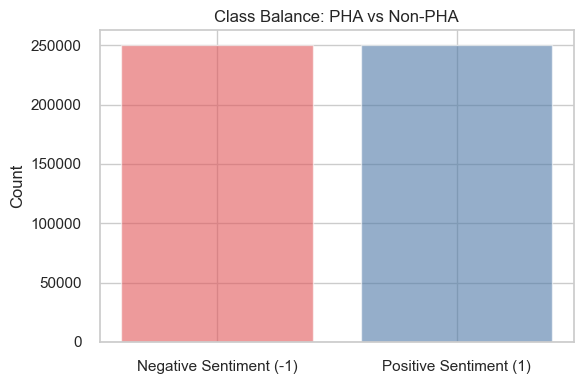

In [56]:
fig, ax = plt.subplots(figsize=(6,4))
counts = balanced_df[SENTIMENT].value_counts().sort_index()
ax.bar(x=['Negative Sentiment (-1)', 'Positive Sentiment (1)'],height=counts.values, color=[NEGATIVE_SENTIMENT,POSITIVE_SENTIMENT], alpha=0.6)
ax.set_title('Class Balance: PHA vs Non-PHA')
ax.set_ylabel('Count')
fig.tight_layout()
plt.savefig('figures/sentiment_class_balance_balanced_df.png')

In [57]:
def showWordcloud(df, saveTo): 
    txt = ' '.join(rev for rev in df.review_text.astype('str'))
    plt.figure(figsize=(15,8))

    wordcloud = WordCloud(
                background_color = 'black',
                max_font_size = 100,
                max_words = 100,
                width = 1000,
                height = 600
                ).generate(txt)


    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis('off')
    plt.savefig(saveTo)
    plt.show()

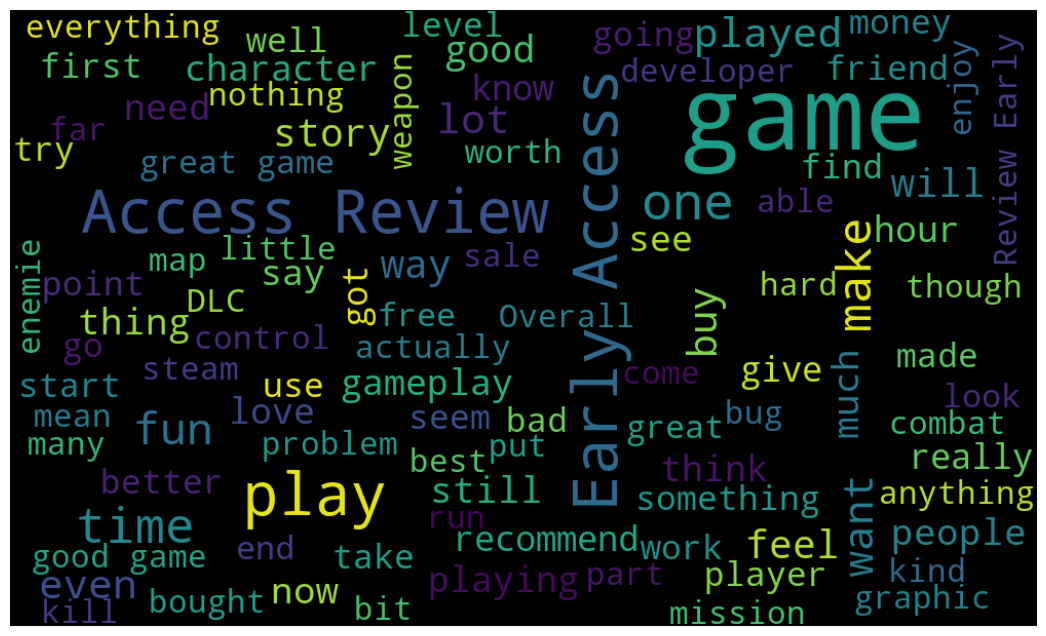

In [58]:
# Wordcloud for review_text
showWordcloud(balanced_df,'figures/wordcloud.png')

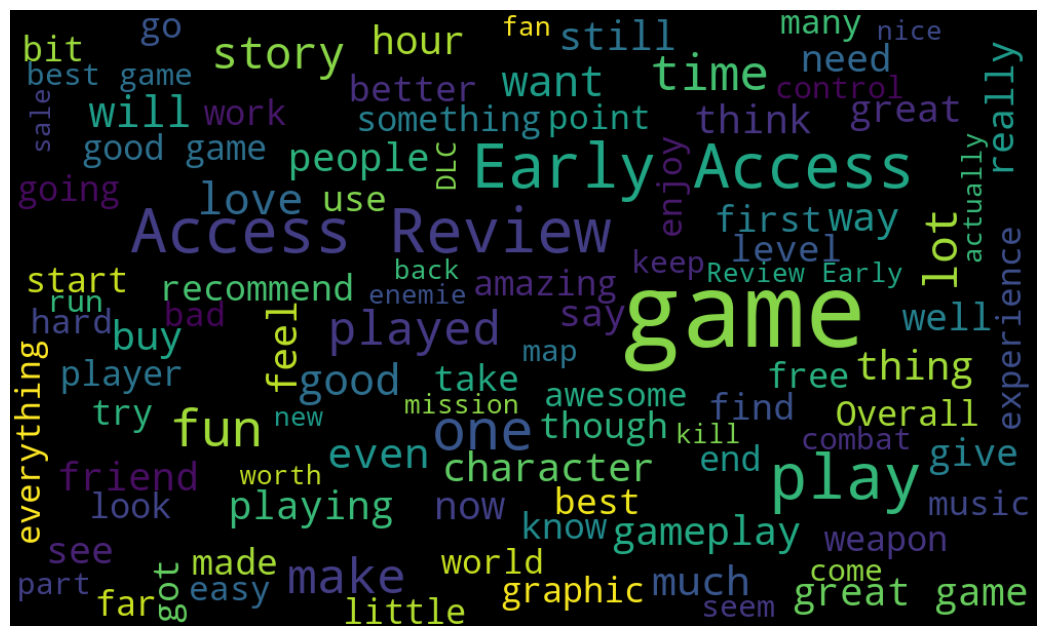

In [ ]:
# Wordcloud for positive sentiment
showWordcloud(balanced_df[balanced_df[SENTIMENT] == 1],'figures/wordcloud_positive.png')

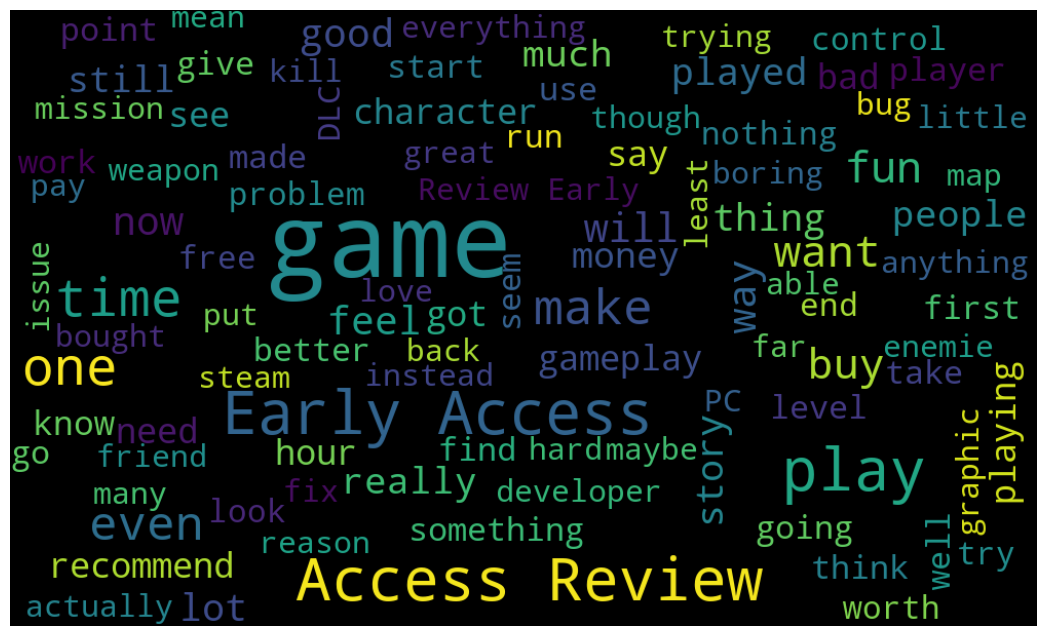

In [60]:
# Wordcloud for negative sentiment
showWordcloud(balanced_df[balanced_df['review_score'] == -1],'figures/wordcloud_negative.png')

In [ ]:
# Dominating Words for both Categories: Does not provide information about sentiment 
# Access Review 
# To validate will check how many with Access Review are there in each sentiment
print(balanced_df['review_text'].unique()) # First Appearance ' Early Access Review'
print('\n Total Count of " Early Access Review" = {}'.format(balanced_df[balanced_df['review_text'] ==  ' Early Access Review']['review_text'].count()))
print('\nCount of " Early Access Review" per sentiment\n')
balanced_df[balanced_df['review_text'].eq(' Early Access Review')].groupby(SENTIMENT).count()
# will drop these records as they are not likely to provide any information about the sentiment of the text

[' Early Access Review'
 "Update:  After finally mustering up the attention span to finish the game, I'd have to say that the last half of the game is extremely underwhelming. There's no satisfying loot. The story ends up becoming a masturbatory tosser by the end. The tactical feel looses its edge as the developers get lazy with balancing and combat scenarios, with the game distilling down to 'tried and true' by character level 10 since the game's enemies never really get more varied or intelligent.  I think the most disappointing part of the game was the last stretch through the Phantom Forest. The story basically is grasping at what uninteresting and forced story elements it's shoved in your face for the last 40 hours of slowly from objective to objective. The 'nature' of the two main characters isn't some sort of revelation at the end, they flaunt it particularly often and it's extremely bothersome at this last third or so of the game. On top of it: the last boss fight is a ♥♥♥♥ing 

,app_id,app_name,review_text,review_votes
review_score,,,,
-1,45796,43413,45796,45796
1,38060,36938,38060,38060


In [62]:
balanced_df = balanced_df[balanced_df['review_text'] != ' Early Access Review']
balanced_df.count()

app_id          416144
app_name        402007
review_text     415607
review_score    416144
review_votes    416144
dtype: int64

In [63]:
# visualize number of words per review:
balanced_df['review_word_count'] = balanced_df['review_text'].apply(lambda sentence: len(str(sentence).split()))
balanced_df.head()

,app_id,app_name,review_text,review_score,review_votes,review_word_count
2,230230,Divinity: Original Sin (Classic),Update: After finally mustering up the attent...,-1,1,1266
3,292500,Kero Blaster,Darn I hate to be the only person to give it a...,-1,1,89
4,212680,FTL: Faster Than Light,Hours played / Money spent = Bargain,1,0,7
5,111900,Guardians of Middle-earth,worst pile of laggy junk ever made,-1,0,7
6,24200,DC Universe Online,daybreak games = dey break games disconnects a...,-1,0,48


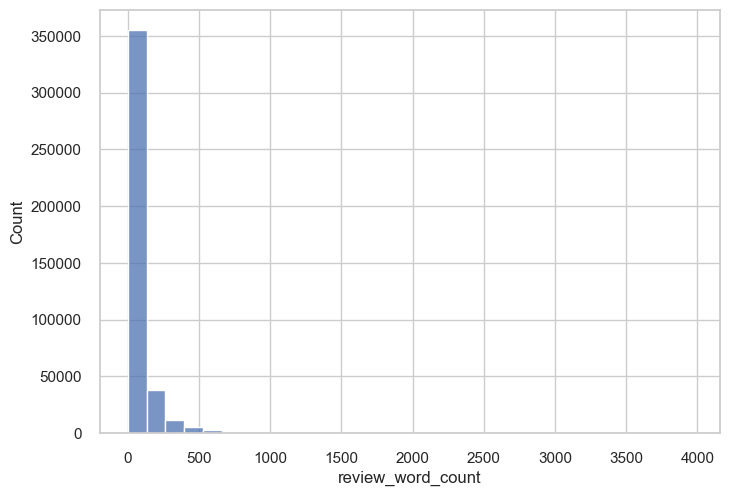

In [64]:
sns.histplot(data=balanced_df, x="review_word_count",bins=30)
plt.savefig("figures/word_count_barchart.png")
# most words are between 0-250 words approx

In [65]:
# Find the most common 20 words
words = (
    balanced_df['review_text']
    .astype(str)
    .str.lower()        
    .str.split()        
    .explode()          
)

# Get top 20 words
top_words = words.value_counts().head(20).reset_index()
top_words.columns = ['Common Words', 'count']

# Display with gradient
top_words.style.background_gradient(cmap='Reds')

,Common Words,count
0,the,1384820
1,and,796426
2,to,788295
3,a,764839
4,i,604664
5,of,560033
6,is,523822
7,game,504424
8,you,490455
9,this,444769


C:\Users\Fatema\AppData\Local\Temp\ipykernel_36896\693011364.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="Common Words", data=top_words, palette='rainbow')


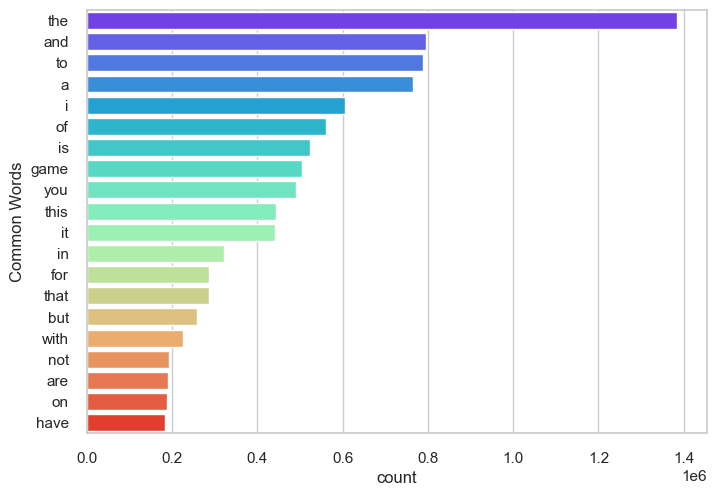

In [66]:
sns.barplot(x="count", y="Common Words", data=top_words, palette='rainbow')
plt.savefig('figures/top_20_words_before_cleaning.png')

In [67]:
# Clean null values
balanced_df.isnull().sum()


app_id                   0
app_name             14137
review_text            537
review_score             0
review_votes             0
review_word_count        0
dtype: int64

In [ ]:
# app_name nulls can be ignored as the model will not use it for sentiment analysis, however 537 records with null review_text will be dropped
balanced_df = balanced_df.dropna(subset=['review_text'])
balanced_df.isnull().sum()

app_id                   0
app_name             14129
review_text              0
review_score             0
review_votes             0
review_word_count        0
dtype: int64

In [69]:
# Remove duplicate values keeping only one occurrence 
balanced_df = balanced_df.drop_duplicates(keep='first')
balanced_df.count()

app_id               407539
app_name             393611
review_text          407539
review_score         407539
review_votes         407539
review_word_count    407539
dtype: int64

In [106]:
# Remove rows with empty string in review_text
balanced_df = balanced_df[balanced_df['review_text'].str.strip() != '']
balanced_df.count()

app_id               407529
app_name             393602
review_text          407529
review_score         407529
review_votes         407529
review_word_count    407529
dtype: int64

#### 2.2 - Text Cleaning & Stemming

In [83]:
# function to remove numbers
def remove_numbers(text):
	return re.sub(r'\d+', '', text)

In [84]:
# function to remove punctuation
def remove_punctuation(text):
	translator = str.maketrans('', '', string.punctuation)
	return text.translate(translator)

In [85]:
# remove whitespace from text
def remove_whitespace(text):
	return " ".join(text.split())

In [86]:
# function to remove stop words 
def remove_stopwords(text):
	filtered_text = [word.lower() for word in text.split() if word.lower() not in STOP_WORDS]
	return filtered_text

In [87]:
# function to remove emojis
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [88]:
# function to remove URLs
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:
# function to remove Markup 

def remove_markup(text):
    # 1) Decode HTML entities (&lt; &amp;quot; ...)
    text = unescape(text)

    # 2) Parse HTML and remove tags
    soup = BeautifulSoup(text, "html.parser")

    # Replace anchor tags content with placeholder if you want
    for a in soup.find_all("a"):
        a.replace_with("Link.")

    # Remove specific tags but keep text (e.g., <i>, <p>)
    for tag in soup.find_all(["i", "p"]):
        tag.unwrap()  # removes tag but keeps inner text

    # 3) Get text and normalize whitespace
    cleaned = soup.get_text(separator=" ", strip=True)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    return cleaned


In [96]:
# Stemming - Using Snowball 
def Stemming(text):
   stem=[]
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [STEMMER.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [99]:
def clean_text_pipeline(
    text: str,
    *,
    remove_markups=True,
    remove_url=True,
    remove_emojis=True,
    remove_punct=True,
    remove_nums=True,
    strip_whitespace=True,
    remove_stop=True,
    stem=True,
) -> str:
    """
    Apply all cleaning steps in a single pass, returning a cleaned sentence.
    Steps can be toggled.
    """
    s = text.lower()

    if remove_markups:
        s = remove_markup(s)

    if remove_url:
        s = remove_urls(s)

    if remove_emojis:
        s = remove_emoji(s)

    if remove_punct:
        s = remove_punctuation(s)

    if remove_nums:
        s = remove_numbers(s)

    if strip_whitespace:
        s = remove_whitespace(s)

    if remove_stop:
        tokens_wo_stop = remove_stopwords(s)
        s = " ".join(tokens_wo_stop)

    if stem:
        s = Stemming(s)

    return s

    

In [104]:
sample = "Testing Full Cleaning Pipeline: https://example.com 😄 <p>I hope it works!</p> 100% ALL_CAP"
print(clean_text_pipeline(sample))

test full clean pipelin hope work allcap


In [108]:
# apply cleaning/stemming to review_text 
balanced_df['review_text'] = balanced_df['review_text'].apply(clean_text_pipeline)

In [109]:
balanced_df.to_csv('data/cleaned_dataset.csv')

In [113]:
balanced_df['review_text'].head(10)

2     updat final muster attent span finish game id ...
3     darn hate person give bad review far go doesnt...
4                         hour play money spent bargain
5                       worst pile laggi junk ever made
6     daybreak game dey break game disconnect almost...
7              awesom game high qualiti good made stori
8     graphic lag realli bad big battl run cpu gig m...
10    nice short point click adventur fair graphic s...
11    darkout version realli wasnt quit sure make ga...
12    never thought id play tactic rpg didnt like th...
Name: review_text, dtype: object

In [111]:
# find top 20 common words after cleaning
# Find the most common 20 words
words = (
    balanced_df['review_text']
    .astype(str)
    .str.lower()        
    .str.split()        
    .explode()          
)

# Get top 20 words
top_words = words.value_counts().head(20).reset_index()
top_words.columns = ['Common Words', 'count']

# Display with gradient
top_words.style.background_gradient(cmap='Reds')

,Common Words,count
0,game,773733
1,play,218222
2,like,161014
3,get,144431
4,time,107788
5,one,104690
6,good,98387
7,realli,90285
8,dont,84479
9,fun,84414


C:\Users\Fatema\AppData\Local\Temp\ipykernel_36896\3011279490.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="Common Words", data=top_words, palette='rainbow')


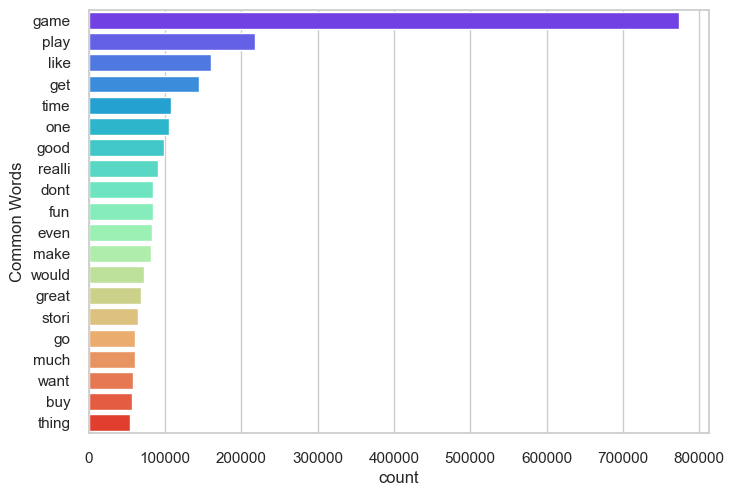

In [112]:
sns.barplot(x="count", y="Common Words", data=top_words, palette='rainbow')
plt.savefig('figures/top_20_words_after_cleaning.png')

### 3- Model Training & Evaluation

In [198]:
def evaluate_results(y_test,ypred):
    conf_matrix = confusion_matrix(y_test,ypred)
    print('Confusion Matrix: \n',classification_report(y_test,ypred,labels=[1,-1]))
    print("\n")
    print('Misclassification Rate: {}'.format(np.divide(np.sum([conf_matrix[0,1],conf_matrix[1,0]]),np.sum(conf_matrix))))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [199]:

def plot_roc(y_true, y_prob, title, path):
    plt.figure(figsize=(6,5))
    RocCurveDisplay.from_predictions(y_true, y_prob, name=title)
    plt.plot([0,1], [0,1], "k--", lw=1)
    plt.title(f"ROC — {title}")
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.show()

def plot_cm(cm, title, path):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.show()


In [ ]:
# split the data
X = balanced_df['review_text']
y = balanced_df[SENTIMENT]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 40, test_size = 0.3)

#### 3.1 - Train Random Forest Classifier

In [200]:
rf_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=4000)), # Bag of words - using only top 4000 features
    ('tfidf', TfidfTransformer()), # Converts raw counts into Term Frequency–Inverse Document Frequency weights.
    ('classifier', RandomForestClassifier()),
    ])

In [ ]:
rf_pipeline.fit(X_train,y_train)

In [203]:
rf_pipeline

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=4000)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [238]:
# Save the model post training
joblib.dump(rf_pipeline, 'models/rf_pipeline.pkl')

['models/rf_pipeline.pkl']

In [ ]:
# Uncomment as needed, however as I ran the above It isn't needed to load the model
# rf_pipeline = joblib.load('models/rf_pipeline.pkl')

In [240]:
rf_predictions = rf_pipeline.predict(X_test)

In [241]:
confusion_matrix(y_test,rf_predictions)

array([[49202, 10322],
       [12364, 50371]])

In [242]:
evaluate_results(y_test,rf_predictions)

Confusion Matrix: 
               precision    recall  f1-score   support

           1       0.83      0.80      0.82     62735
          -1       0.80      0.83      0.81     59524

    accuracy                           0.81    122259
   macro avg       0.81      0.81      0.81    122259
weighted avg       0.81      0.81      0.81    122259



Misclassification Rate: 0.18555689151718893
ROC-AUC 0.8147539934343877


<Figure size 600x500 with 0 Axes>

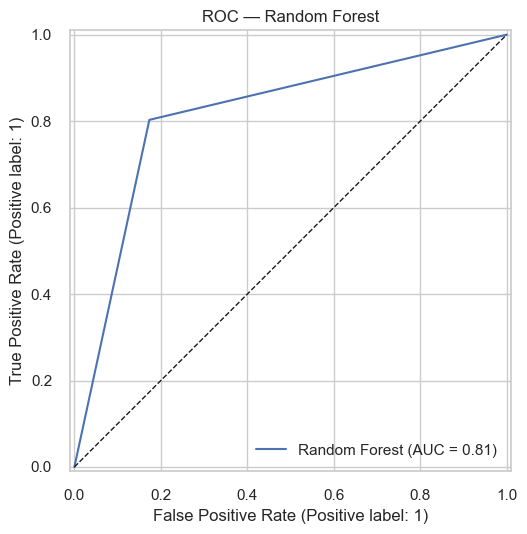

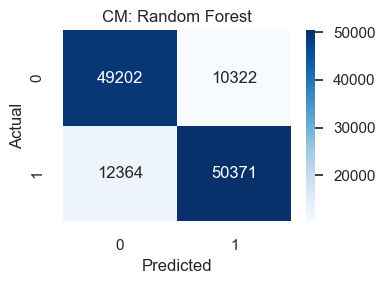

In [243]:
# Plots
plot_roc(y_test, rf_predictions, "Random Forest", "figures/roc_rf.png")
plot_cm (confusion_matrix(y_test,rf_predictions), "CM: Random Forest", "figures/cm_rf.png")

### 3.2 - Train Logistic Regression Classifier

In [ ]:
KV_PATH = Path("models") / "w2v_steam.kv"
KV_PATH.parent.mkdir(parents=True, exist_ok=True)

def get_or_train_keyedvectors(X_train, vector_size=100, window=5, sg=1, min_count=2, workers=4, epochs=5):
    """
    Load cached KeyedVectors if present; otherwise train Word2Vec, save .kv, and return KeyedVectors.
    """
    if KV_PATH.exists():
        print(f"[Word2Vec] Loading cached KeyedVectors: {KV_PATH}")
        t0 = time.time()
        wv = KeyedVectors.load(str(KV_PATH), mmap='r')
        print(f"[Word2Vec] Loaded in {time.time() - t0:.2f}s")
        return wv

    # Not cached → train a Wo2Vec model and export only the vectors
    print("[Word2Vec] Training new model to export KeyedVectors…")
    t0 = time.time()
    train_tokens = [simple_preprocess(doc, deacc=True) for doc in X_train]
    model = Word2Vec(
        sentences=train_tokens,
        vector_size=vector_size,
        window=window,
        sg=sg,
        min_count=min_count,
        workers=workers,
        epochs=epochs
    )
    print(f"[Word2Vec] Trained in {time.time() - t0:.2f}s")

    # Save the vectors only (lighter to load)
    model.wv.save(str(KV_PATH))
    print(f"[Word2Vec] Saved KeyedVectors to {KV_PATH}")
    return model.wv

wv = get_or_train_keyedvectors(X_train)


[Word2Vec] Loading cached KeyedVectors: models\w2v_steam.kv
[Word2Vec] Loaded in 0.02s


In [223]:
word_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=4000, min_df=5, sublinear_tf=True) # use ngrams up to 2 words, limit to top 4000 features
char_tfidf = TfidfVectorizer(analyzer="char", ngram_range=(3, 5), min_df=5, sublinear_tf=True) # char ngrams from 3 to 5
hashing = HashingVectorizer(n_features=2**18, alternate_sign=False, ngram_range=(1, 2)) 


class W2VAvg(BaseEstimator, TransformerMixin):
    def __init__(self, model, dim=100): self.model, self.dim = model, dim
    def fit(self, X, y=None): return self
    def transform(self, X):
        out = []
        for doc in X:
            toks = simple_preprocess(doc, deacc=True)
            vecs = [self.model.wv[w] for w in toks if w in self.model.wv]
            out.append(np.mean(vecs, axis=0) if vecs else np.zeros(self.dim, dtype=np.float32))
        return np.vstack(out).astype("float32")



emb_branch = Pipeline([
    ("w2v", W2VAvg(model=w2v_model, dim=w2v_model.vector_size)),
    ("scale", StandardScaler())
])


'''
FeatureUnion allows us to combine multiple feature extraction mechanisms into a single feature space.
Benefits:
    Parallel feature spaces: You want to extract different kinds of features from the same input (e.g., one branch builds word‑level TF‑IDF, another builds char‑level TF‑IDF, another computes dense document embeddings).
    Modularity: Each branch can have its own vectorizer/transformer and hyper‑parameters.
    End‑to‑end pipelines: Works nicely inside a Pipeline so you can fit/transform and cross‑validate everything together.
'''
features = FeatureUnion([
    ("word_tfidf", word_tfidf),
    ("char_tfidf", char_tfidf),
    ("hashing", hashing),
    ("embeddings", emb_branch),
])


lr = LogisticRegression(
    solver="liblinear", max_iter=1000, C=1.0, class_weight="balanced"
)

lr_pipeline = Pipeline([
    ("features", features),
    ("clf", lr)
])



In [224]:
# Train LR
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('word_tfidf',
                                                 TfidfVectorizer(max_features=4000,
                                                                 min_df=5,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 sublinear_tf=True)),
                                                ('char_tfidf',
                                                 TfidfVectorizer(analyzer='char',
                                                                 min_df=5,
                                                                 ngram_range=(3,
                                                                              5),
                                                                 sublinear_tf=True)),
                                                ('hashing',
                                                 HashingVectorizer(alternate_sign=False,
                                                                   n_features=262144,
                                                                   ngram_range=(1,
                                                                                2))),
                                                ('embeddings',
                                                 Pipeline(steps=[('w2v',
                                                                  W2VAvg(model=<gensim.models.word2vec.Word2Vec object at 0x000001AF896D95B0>)),
                                                                 ('scale',
                                                                  StandardScaler())]))])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

In [ ]:
# Save the model post training
joblib.dump(lr_pipeline, 'models/lr_pipeline.pkl')

['models/lr_pipeline.pkl']

In [ ]:
# Uncomment as needed, however as I ran the above It isn't needed to load the model
# lr_pipeline = joblib.load('models/lr_pipeline.pkl')

In [234]:

lr_predictions = lr_pipeline.predict(X_test)

In [235]:
confusion_matrix(y_test,lr_predictions)

array([[50907,  8617],
       [ 8309, 54426]])

In [236]:
evaluate_results(y_test,lr_predictions)

Confusion Matrix: 
               precision    recall  f1-score   support

           1       0.86      0.87      0.87     62735
          -1       0.86      0.86      0.86     59524

    accuracy                           0.86    122259
   macro avg       0.86      0.86      0.86    122259
weighted avg       0.86      0.86      0.86    122259



Misclassification Rate: 0.13844379554879396
ROC-AUC 0.8613944301099127


<Figure size 600x500 with 0 Axes>

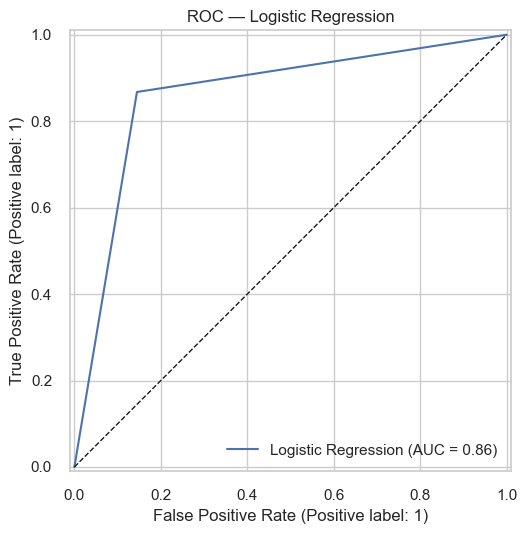

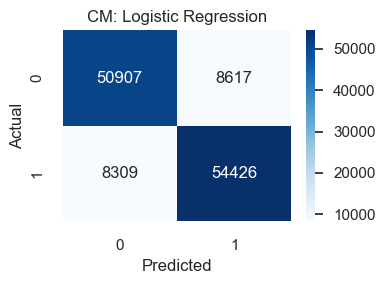

In [246]:
# Plots
plot_roc(y_test, lr_predictions, "Logistic Regression", "figures/roc_lr.png")
plot_cm (confusion_matrix(y_test,lr_predictions), "CM: Logistic Regression", "figures/cm_lr.png")

#### 3.3 - Compare the Models - Random Forest vs Logistic Regression